# <font color=blue>*Natural language Processing Applications - Example Codes*</font> 

# *Chapter-4 $<$Name of Chapter$>$* 
## Welcome to the second notebook of Chapter-4. This notebook aims to give you a brief overview of *Spam Filtering* and Naive Bayes Classifier.

# <font color= blue> Spam Filtering Using Naive Bayes. </font>  

Mails are one of the major ways of official communications and out mail servers are having algorithm to tag any incoming mail as spam and move the same to a certain folder named "SPAM Folder"
Below we are going to see an experiment on the similar case and taking some sample mail we shall build a supervised classification model to detect the given mail is spam or not.

#### We are using use Enron dataset for this experimentation: 
##### Dataset Link: http://www2.aueb.gr/users/ion/data/enron-spam/

It contains a preclassified text files containing mails. 
### Please feel free to download and experiment on the same. Please download and save the data by creating a folder named   "dataset"

#### Let's import few necessary packages before we start our work

In [36]:
import glob
import pandas as pd
import os
from collections import Counter
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.metrics import confusion_matrix 
import numpy as np 
import scipy as sp 
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 
import pandas as pd 
import nltk
import re
import csv
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import SGDClassifier
from scipy.sparse import hstack
from sklearn.metrics import confusion_matrix
from time import time
%matplotlib inline

### Section 1: Load the dataset

#### Generally you may receive multiple text files on Enron dataset which needs to be merged and leveled for further analysis. We are going to create a data frame file containing two columns. Data frame is just like our excel file with different columns and rows. Column represents the type of field and rows represents the data element 
        Text -> This column would contain the text body of each mail
        Class -> This column contains the lebel of whether the mail is 'spam' or 'ham'

#### First step is to create a data-frame with two columns: 
<br>
* <b>Text</b>: The extracted texts from each mail. 
* <b>Class</b>: Represents whether it is "Spam" and "Ham

In [2]:
spam_data = pd.DataFrame(columns = ("Text", "Class")) #this will create an empty data frame

In [3]:
for cla in glob.glob("Datasets/*"): # Here the folder name is data set in which there are two sub-folder "Spam" & "Ham"
    clas = cla.split(os.sep)[1]    # We are splitting the folder names as class using OS-Seperator and taking the 2nd item in the list
    for file in glob.glob(cla + "/*.txt"): # Here we are deep diving in each of the folder and reading the text files one by one
        text = open(file, "r", encoding = "ISO-8859-1").read() # Reading the file , for Windows generally we need to mention the encoding 
        text = " ".join(text.split("\n")) # Splitting the text files and rejoining into a single text
        spam_data = spam_data.append(pd.Series([text, clas], index = ["Text", "Class"]), ignore_index = True) # continious append to the data frame

### Section 2: Explore the dataset.

In [4]:
spam_data.head()

,Text,Class
0,Subject: christmas tree farm pictures,ham
1,"Subject: vastar resources , inc . gary , produ...",ham
2,Subject: calpine daily gas nomination - calpin...,ham
3,Subject: re : issue fyi - see note below - alr...,ham
4,Subject: meter 7268 nov allocation fyi . - - -...,ham


### Lets check the distribution of classes. 

In [5]:
spam_data['Class'].value_counts() / spam_data.shape[0]

ham     0.709977
spam    0.290023
Name: Class, dtype: float64

#### There is slight imbalance in the data with *Ham* being 70% in the dataset.

#### Converting the class label into binary outcome variable for convenience.
* 1- in case the mail is a spam mail

* 0- in case the mail is not a spam

In [6]:
# convert label to a numerical variable
spam_data['Class'] = spam_data.Class.map({'ham':0, 'spam':1})

### Section 3: Data Cleaning

#### As next step we need to clean the data and remove stopwords:
    This involves cleaning of alpha neumerical characters/ special characters "@" , "-", "1" etc
    Any stop words

In [7]:
stop = set(stopwords.words('english'))

In [8]:
spam_complete = spam_data['Text'].tolist()

In [9]:
len(spam_complete)

5172

In [10]:
spam_complete[5]

'Subject: mcmullen gas for 11 / 99 jackie , since the inlet to 3 river plant is shut in on 10 / 19 / 99 ( the last day of flow ) : at what meter is the mcmullen gas being diverted to ? at what meter is hpl buying the residue gas ? ( this is the gas from teco , vastar , vintage , tejones , and swift ) i still see active deals at meter 3405 in path manager for teco , vastar , vintage , tejones , and swift i also see gas scheduled in pops at meter 3404 and 3405 . please advice . we need to resolve this as soon as possible so settlement can send out payments . thanks'

In [11]:
spam_complete[7]

"Subject: duns number changes fyi - - - - - - - - - - - - - - - - - - - - - - forwarded by gary l payne / hou / ect on 12 / 14 / 99 02 : 35 pm - - - - - - - - - - - - - - - - - - - - - - - - - - - from : antoine v pierre 12 / 14 / 99 02 : 34 pm to : tommy j yanowski / hou / ect @ ect , kathryn bussell / hou / ect @ ect , gary l payne / hou / ect @ ect , diane e niestrath / hou / ect @ ect , romeo d ' souza / hou / ect @ ect , michael eiben / hou / ect @ ect , clem cernosek / hou / ect @ ect , scotty gilbert / hou / ect @ ect , dave nommensen / hou / ect @ ect , david rohan / hou / ect @ ect , kevin heal / cal / ect @ ect , richard pinion / hou / ect @ ect cc : mary g gosnell / hou / ect @ ect , jason moore / hou / ect @ ect , samuel schott / hou / ect @ ect , bernice rodriguez / hou / ect @ ect subject : duns number changes i will be making these changes at 11 : 00 am on wednesday december 15 . if you do not agree or have a problem with the dnb number change please notify me , otherwis

#### if you see some of the documents (mails) above. These are prior to cleaning the document.
Let's create a function to clean the text with different sub-function

In [12]:
def clean(doc):
    doc = " ".join([i.replace('*', '') for i in doc.lower().split()])
    doc = " ".join([i.replace(':', ' ') for i in doc.split()])
    doc = " ".join([i.replace('.', ' ') for i in doc.split()])
    doc = " ".join([i.replace('=', '') for i in doc.split()])
    doc = " ".join([i.replace('/', ' ') for i in doc.split()])
    doc = " ".join([i.replace(')', ' ') for i in doc.split()])
    doc = " ".join([i.replace('(', ' ') for i in doc.split()])
    doc = " ".join([i.replace('"', ' ') for i in doc.split()])
    doc = " ".join([i.replace('-', ' ') for i in doc.split()])
    doc = " ".join([i.replace('_', ' ') for i in doc.split()])
    doc = " ".join([i for i in doc.split() if not i.isdigit()])
    doc = " ".join([i for i in doc.split() if i.isalpha()])
    doc = " ".join([i for i in doc.split() if i not in stop])
    return doc

In [13]:
spam_clear = [clean(doc) for doc in spam_complete]

In [14]:
spam_clear[7]

'subject duns number changes fyi forwarded gary l payne hou ect pm antoine v pierre pm tommy j yanowski hou ect ect kathryn bussell hou ect ect gary l payne hou ect ect diane e niestrath hou ect ect romeo souza hou ect ect michael eiben hou ect ect clem cernosek hou ect ect scotty gilbert hou ect ect dave nommensen hou ect ect david rohan hou ect ect kevin heal cal ect ect richard pinion hou ect ect cc mary g gosnell hou ect ect jason moore hou ect ect samuel schott hou ect ect bernice rodriguez hou ect ect subject duns number changes making changes wednesday december agree problem dnb number change please notify otherwise make change scheduled dunns number change counterparty cp id number cinergy resources inc energy dynamics management inc south jersey resources group llc transalta energy marketing us inc philadelphia gas works thanks rennie'

#### Map this clean text in the same dataframe, for that we have created a new column named clean_text.

In [15]:
spam_data["clean_text"] = spam_clear

In [16]:
spam_data.head()

,Text,Class,clean_text
0,Subject: christmas tree farm pictures,0,subject christmas tree farm pictures
1,"Subject: vastar resources , inc . gary , produ...",0,subject vastar resources inc gary production h...
2,Subject: calpine daily gas nomination - calpin...,0,subject calpine daily gas nomination calpine d...
3,Subject: re : issue fyi - see note below - alr...,0,subject issue fyi see note already done stella...
4,Subject: meter 7268 nov allocation fyi . - - -...,0,subject meter nov allocation fyi forwarded lau...


### We will use only two columns viz *Class* and *clean_text* for modelling so take out these columns and create a new data frame

In [19]:
spam_data_ABT=spam_data[["Class","clean_text"]]

In [20]:
spam_data_ABT.head()

,Class,clean_text
0,0,subject christmas tree farm pictures
1,0,subject vastar resources inc gary production h...
2,0,subject calpine daily gas nomination calpine d...
3,0,subject issue fyi see note already done stella...
4,0,subject meter nov allocation fyi forwarded lau...


### Section 4: Modelling 

#### Now we are ready for the modelling. We are going to use algorithms from sklearn package:

#### Background of train/test split

* Train/test split is for model evaluation
* Model evaluation is to simulate the future
* Past data is exchangeable for future data
* We pretend some of our past data is coming into our future data
* By training, predicting and evaluating the data, we can check the performance of our model

#### Vectorize then split

* If we vectorize then we train/test split, our document-term matrix would contain every single feature (word) in the test and training sets
* What we want is to simulate the real world
* We would always see words we have not seen before so this method is not realistic and we cannot properly evaluate our models

#### Split then vectorize (correct way)

* We do the train/test split before the CountVectorizer to properly simulate the real world where our future data contains words * we have not seen before
* After you train your data and chose the best model, you would then train on all of your data before predicting actual future data to maximize learning.

In [21]:
# how to define X and y (from the mail spam data) for use with COUNTVECTORIZER
X = spam_data_ABT.clean_text
y = spam_data_ABT.Class
print(X.shape)
print(y.shape)

(5172,)
(5172,)


In [22]:
# split X and y into training and testing sets
# by default, it splits 75% training and 25% test
# random_state=1 for reproducibility
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3879,)
(1293,)
(3879,)
(1293,)


<font color=blue>**CountVectorizer**</font> converts the given text into lower case, extract tokens, remove stop words and builts the Vocabulary which helps to encode the new text data.It usually works in three steps: 
* Creating an instance of CountVectorizer class.
<br>
* Fit this instance on our data, this step is responsible to create the vocabulary. 
<br>
* transform() function is reponsible to do the encoding. 

We can combine the step two and three into a single step as done below.

In [24]:
vect = CountVectorizer() #Step-1
X_train_dtm = vect.fit_transform(X_train)#combined step 2 and 3

In [26]:
X_train_dtm.shape

(3879, 39159)

In [28]:
#transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm.shape

(1293, 39159)

#### The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

In [29]:
nb = MultinomialNB() #instantiate a Multinomial Naive Bayes model

In [30]:
%time nb.fit(X_train_dtm, y_train)#train the model(timing it with an IPython "magic command")

Wall time: 15.6 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [31]:
y_pred_class = nb.predict(X_test_dtm)#make class predictions for X_test_dtm

In [32]:
# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.97757153905645788

In [33]:
# examine class distribution
print(y_test.value_counts())
# there is a majority class of 0 here, hence the classes are skewed

# calculate null accuracy (for multi-class classification problems)
# .head(1) assesses the value 1208
null_accuracy = y_test.value_counts().head(1) / len(y_test)
print('Null accuracy:', null_accuracy)

# Manual calculation of null accuracy by always predicting the majority class
print('Manual null accuracy:',(1208 / (1208 + 185)))

0    921
1    372
Name: Class, dtype: int64
Null accuracy: 0    0.712297
Name: Class, dtype: float64
Manual null accuracy: 0.8671931083991385


### Plot the Confusion Matrix 

In [37]:
# Function to plot confusion matrix. 
# Ref:http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

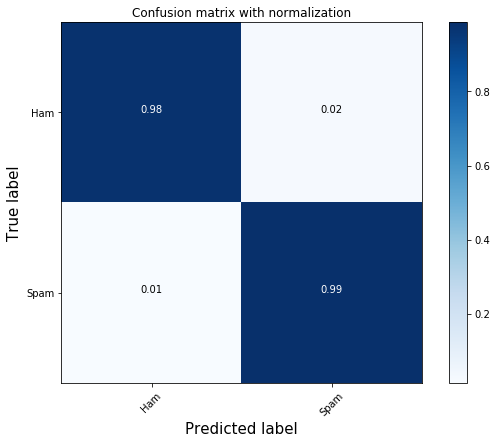

In [56]:
# print the confusion matrix
#metrics.confusion_matrix(y_test, y_pred_class)

cnf_matrix = confusion_matrix(y_test, y_pred_class)

plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Ham','Spam'],normalize=True,
                      title='Confusion matrix with normalization')

### Confusion matrix 


#### [True Negative, False Positive

#### False Negative, True Positive]

For further reading : https://en.wikipedia.org/wiki/Confusion_matrix

In [43]:
# print message text for the false positives (ham incorrectly classified as spam)

X_test[y_pred_class > y_test]



3597    subject important video announcement important...
3539    subject dear wish find mission kosovo find new...
2456    subject hunter singing christmas program video...
126     subject fw quips remember amateurs built ark p...
2068    subject skydive spaceland specials skydive spa...
301     subject expatriate zone issue expatriate zone ...
2772    subject boat believe boat ft long boat cover b...
2479    subject weekly fan fares delta fan fares febru...
304     subject http www pge texas com www gtt nsf htm...
107     subject new email yo bro new email address sav...
Name: clean_text, dtype: object

In [44]:
# print message text for the false negatives (spam incorrectly classified as ham)

X_test[y_pred_class < y_test]


3835                 subject multiple ways get home loans
3789                                              subject
4932    subject hello mail transaction failed partial ...
3743                              subject holiday e cards
4728                                              subject
4423                                        subject enjoy
5168          subject str rndlen extra time word bodyhtml
4646    subject investigation tue jan sir trouble gett...
4657                               subject hi try nothing
3971    subject thu may first gove rnment mo rtgage pr...
3830           subject document please read attached file
3815    subject feeling slze johnson rtxyj nxfgr ktrqr...
4181    subject network wed aug kttihkefi iewmeh ckust...
4684                                              subject
4830                                         subject note
4498    subject promised help people please refer ques...
3748                    subject holiday e cards gbhzivjwl
4593          

#### Area under the curve(AUC) gives idea about the model efficiency:
we can use this to compare to different models to benchmark their performance

Further information: https://en.wikipedia.org/wiki/Receiver_operating_characteristic

In [45]:
# calculate AUC
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
metrics.roc_auc_score(y_test, y_pred_prob)

0.99664051463463044

### let's try another model and see if the accuracy changes or there is any change to the AUC, for experiment we have considered logistic regression.

In [51]:
from sklearn.linear_model import LogisticRegression #import

logreg = LogisticRegression() #instantiate a logistic regression model

In [52]:
# 3. train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)

Wall time: 266 ms


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [53]:
# 4. make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)

In [54]:
# calculate accuracy
metrics.accuracy_score(y_test, y_pred_class)

0.97911832946635735

In [55]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.99664051463463044

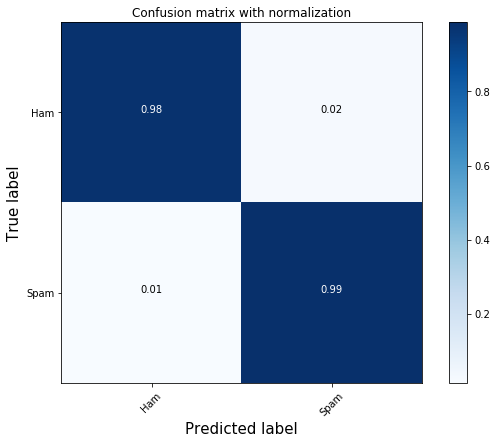

In [58]:
cnf_matrix = confusion_matrix(y_test, y_pred_class)

plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Ham','Spam'],normalize=True,
                      title='Confusion matrix with normalization')